# Network Packet Analysis 

First of al we will be importing all of the libaries that we will be using for this project.

We also sniff number of packets given to the program and assign those to pcap.

In [1]:
from scapy.all import * # For Packet manipulation
import pandas as pd 
import numpy as np 
import binascii  
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

num_of_packets_to_sniff = 100
pcap = sniff(count=num_of_packets_to_sniff)

print(type(pcap))
print(len(pcap))
print(pcap)
pcap[0]

<class 'scapy.plist.PacketList'>
100
<Sniffed: TCP:37 UDP:61 ICMP:0 Other:2>


<Ether  dst=01:00:5e:7f:ff:fa src=34:60:f9:2a:03:5c type=IPv4 |<IP  version=4 ihl=5 tos=0x0 len=684 id=17293 flags= frag=0 ttl=1 proto=udp chksum=0x739b src=10.100.5.187 dst=239.255.255.250 |<UDP  sport=56802 dport=ws_discovery len=664 chksum=0xadca |<Raw  load='<?xml version="1.0" encoding="utf-8"?><soap:Envelope xmlns:soap="http://www.w3.org/2003/05/soap-envelope" xmlns:wsa="http://schemas.xmlsoap.org/ws/2004/08/addressing" xmlns:wsd="http://schemas.xmlsoap.org/ws/2005/04/discovery"><soap:Header><wsa:To>urn:schemas-xmlsoap-org:ws:2005:04:discovery</wsa:To><wsa:Action>http://schemas.xmlsoap.org/ws/2005/04/discovery/Resolve</wsa:Action><wsa:MessageID>urn:uuid:2e64645d-247e-4646-8dfe-e9e241ebcfe0</wsa:MessageID></soap:Header><soap:Body><wsd:Resolve><wsa:EndpointReference><wsa:Address>urn:uuid:a1fa8468-48db-f7d1-c3d3-e3ff998558e6</wsa:Address></wsa:EndpointReference></wsd:Resolve></soap:Body></soap:Envelope>' |>>>>

### Append suspicious pcap to current stream

Since we want to see if the project picks up suspicious packets and allerts us regarding some of the adresses that have high load we will add a pcap file that we know has high load.

In [2]:
# rdpcap used to Read Pcap
pcap = pcap + rdpcap("high_payload_burst.pcap")
pcap

<Sniffed+high_payload_burst.pcap: TCP:47 UDP:61 ICMP:0 Other:2>

# TCP design for analysis

Lets look at how Transmission control protocol looks like in design so that we now what we are looking for.

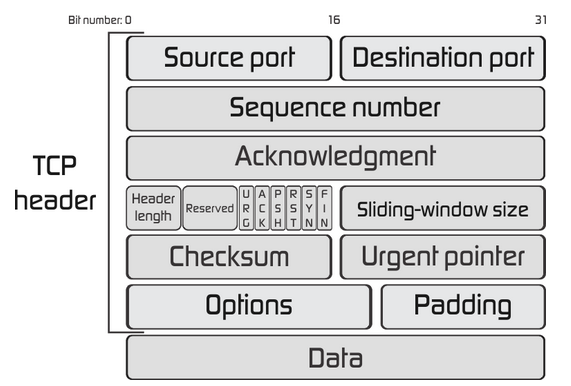

In [3]:
from IPython.display import Image
Image(filename='TCP-segment.png') 

Now we have to figure out how to get hold of the information we need using dataframes.

### Importing layers in scrapy

We import the layers of scrapy which we will use to collect IP/TCP/UDP fields and represent them in DataFrame 

In [4]:

from scapy.layers.l2 import Ether
from scapy.layers.inet import IP
from scapy.layers.inet import TCP, UDP

print("UDP", pcap[UDP])

UDP <UDP from Sniffed+high_payload_burst.pcap: TCP:0 UDP:61 ICMP:0 Other:0>


# Convert PCAP to DataFrame

Here now that we understand the way the pcaps look and can sort them by layers we can convert them into DataFrame and afterwards plot certain statistics from it. 

Through the code below we build a dataframe where we have the columns of source, destination, source port and destination port.

In [5]:
# Collect field names from IP/TCP/UDP (These will be columns in DF)
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Create blank DataFrame
df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    # Field array for each row of DataFrame
    field_values = []
    # Add all IP fields to dataframe
    for field in ip_fields:
        if field == 'options':
            # Retrieving number of options defined in IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Append payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Add row to DF
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

### DataFrame Basics

In [6]:
# Returning Source Address, Destination Address, Source Port, Destination Port as a table
df[['src','dst','sport','dport']]

,src,dst,sport,dport
0,10.100.5.187,239.255.255.250,56802,3702
1,10.100.3.235,239.255.255.250,54409,1900
2,10.100.6.62,239.255.255.250,49153,1900
3,192.168.0.192,18.64.103.43,51234,443
4,192.168.0.192,18.64.103.43,51234,443
...,...,...,...,...
94,192.168.1.1,192.168.1.2,20,80
95,192.168.1.1,192.168.1.2,20,80
96,192.168.1.1,192.168.1.2,20,80
97,192.168.1.1,192.168.1.2,20,80


# Statistics

Lets find the top adresses for the source and destination, and see their frequency.

In [7]:
print("Top Source Addresses found:")
print(df['src'].describe())

print("Top Destination Addresses found:")
print(df['dst'].describe())

frequent_address = df['src'].describe()['top']

print("Which adress is top Address Speaking to?")
print(df[df['src'] == frequent_address]['dst'].unique())

print("Which adress is the top address speaking to (Destination Ports)")
print(df[df['src'] == frequent_address]['dport'].unique())


print("Which adress is the top address speaking to (Source Ports)")
print(df[df['src'] == frequent_address]['sport'].unique())

Top Source Addresses found:
count                99
unique               14
top       192.168.0.192
freq                 36
Name: src, dtype: object
Top Destination Addresses found:
count                99
unique               12
top       192.168.0.192
freq                 37
Name: dst, dtype: object
Which adress is top Address Speaking to?
['18.64.103.43' '35.186.224.25' '192.168.0.1' '142.251.209.133'
 '104.18.88.228' '142.251.209.138' '184.105.99.75' '3.211.230.2']
Which adress is the top address speaking to (Destination Ports)
[443 53]
Which adress is the top address speaking to (Source Ports)
[51234 56012 53213 49367 50060 50557 57311 52512 51459 55526 60192 56377
 52712 63875 52713 52513]


In [8]:
# Unique Source Addresses
print("Unique Source Addresses found:")
print(df['src'].unique())

print()

# Unique Destination Addresses
print("Unique Destination Addresses found:")
print(df['dst'].unique())

Unique Source Addresses found:
['10.100.5.187' '10.100.3.235' '10.100.6.62' '192.168.0.192' '192.168.0.1'
 '18.64.103.43' '35.186.224.25' '142.251.209.133' '104.18.88.228'
 '10.100.9.219' '142.251.209.138' '3.211.230.2' '184.105.99.75'
 '192.168.1.1']

Unique Destination Addresses found:
['239.255.255.250' '18.64.103.43' '35.186.224.25' '192.168.0.1'
 '192.168.0.192' '142.251.209.133' '104.18.88.228' '142.251.209.138'
 '192.168.0.255' '184.105.99.75' '3.211.230.2' '192.168.1.2']


# Graphing

Now that we have the dataframe. Lets see the tables we can plot using groupby function. 

I will also import matplot for some of the graphs

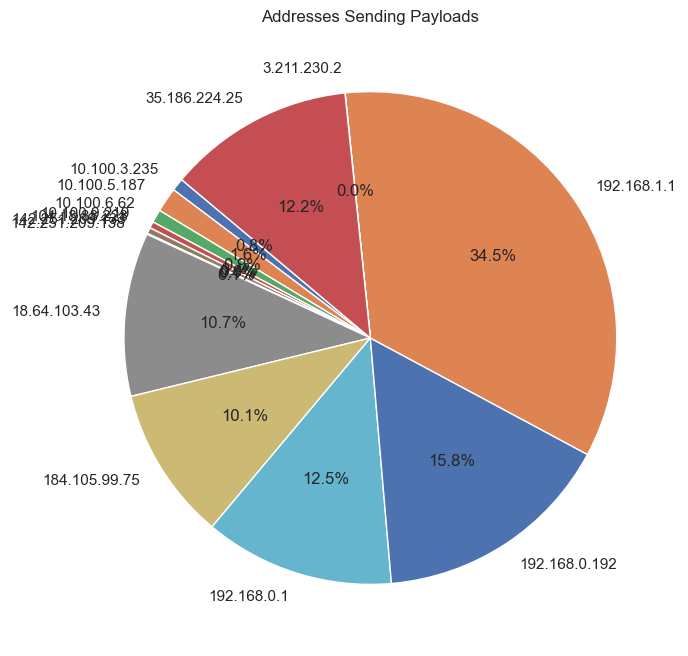

In [9]:
import matplotlib.pyplot as plt

# Group by Source Address and Payload Sum
source_addresses = df.groupby("src")['payload'].sum()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(source_addresses, labels=source_addresses.index, autopct='%1.1f%%', startangle=140)
plt.title("Addresses Sending Payloads")

plt.show()


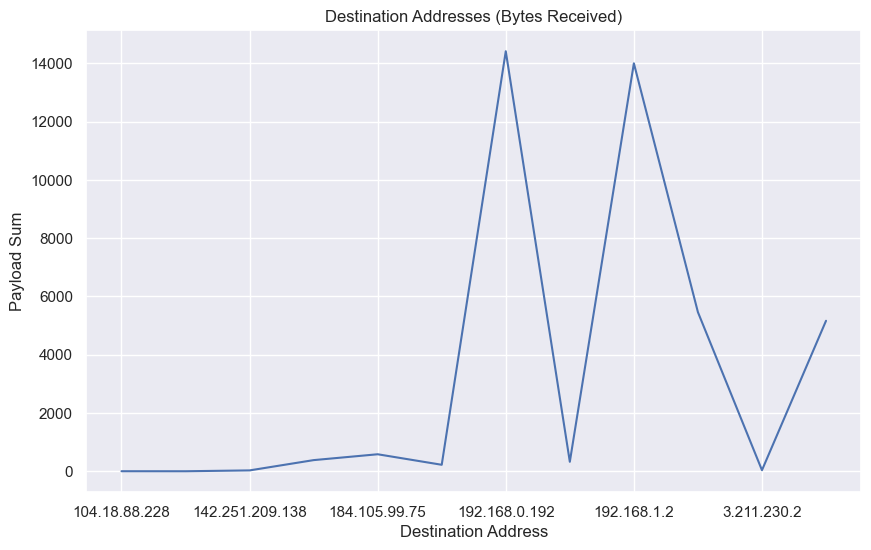

In [10]:
# Group by Destination Address and Payload Sum
destination_addresses = df.groupby("dst")['payload'].sum()

# Create a line chart
destination_addresses.plot(kind='line', title="Destination Addresses (Bytes Received)", figsize=(10, 6))
plt.xlabel("Destination Address")
plt.ylabel("Payload Sum")
plt.show()


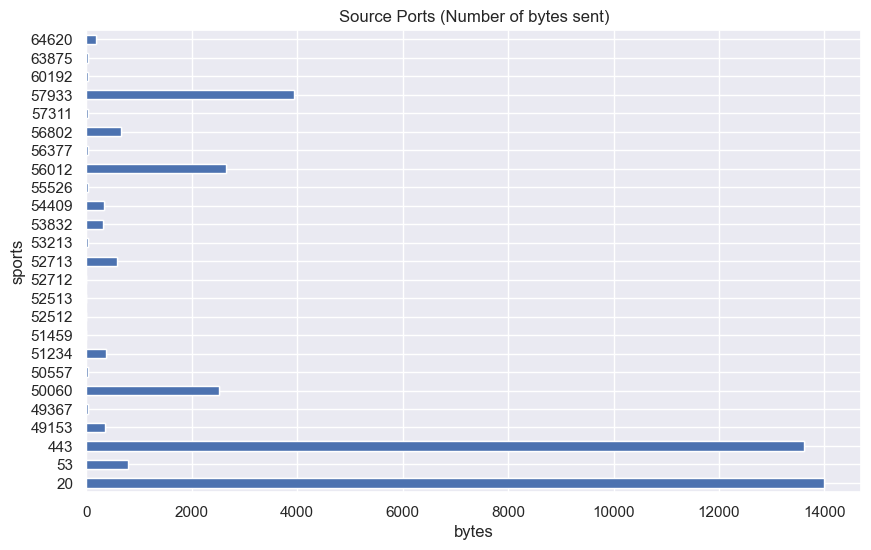

In [11]:
# Group by SourcePort and Payload Sum
source_payload = df.groupby("sport")['payload'].sum()
source_payload.plot(kind='barh',title="Source Ports (Number of bytes sent)",figsize=(10,6))

source_payload.plot(kind='barh', title="Source Ports (Number of bytes sent)", figsize=(10, 6))
plt.xlabel("bytes")
plt.ylabel("sports")
plt.show()

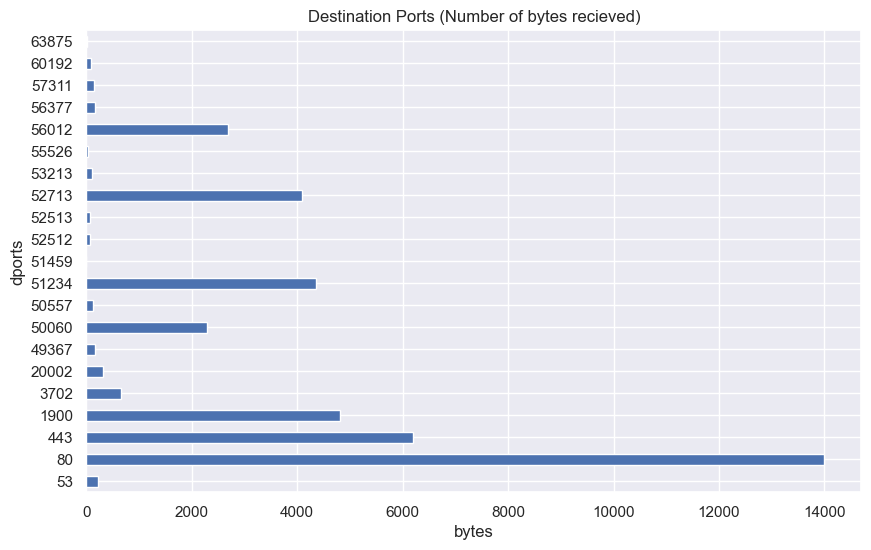

In [12]:
# Group by Destination Port and Payload Sum
destination_payload = df.groupby("dport")['payload'].sum()

destination_payload.plot(kind='barh', title="Destination Ports (Number of bytes recieved)", figsize=(10, 6))
plt.xlabel("bytes")
plt.ylabel("dports")
plt.show()


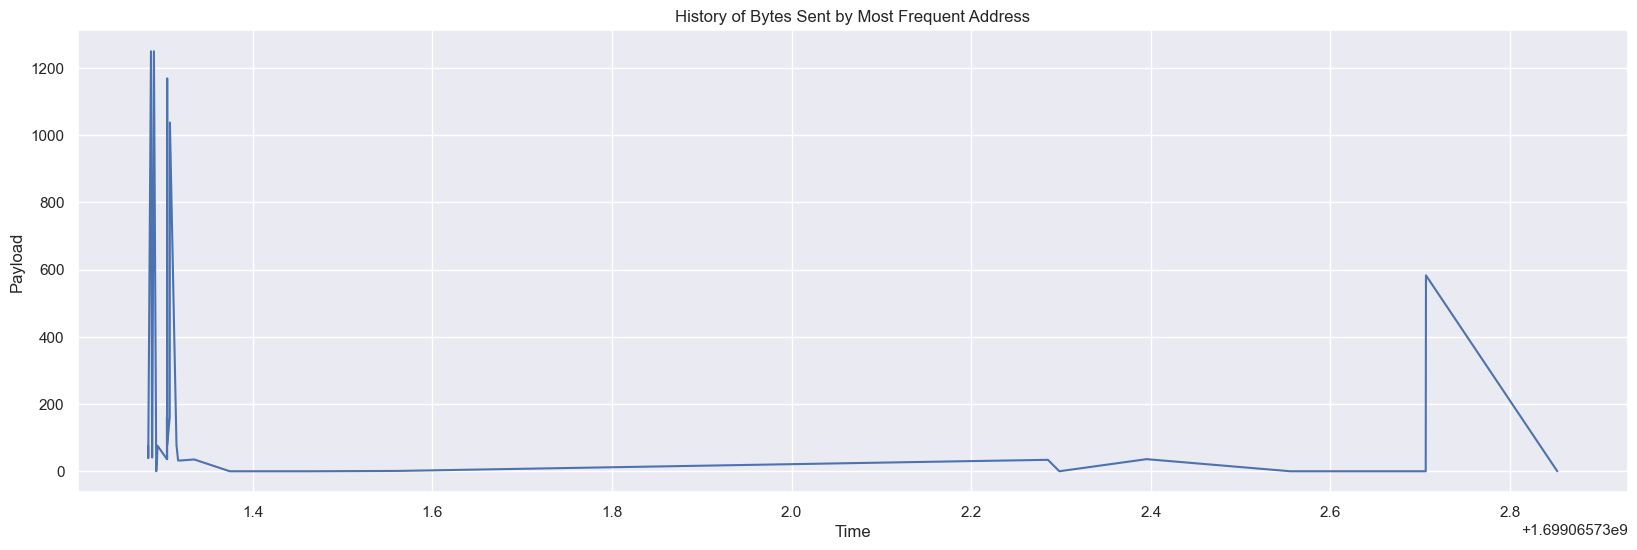

In [13]:

frequent_address_df = df[df['src'] == frequent_address]


plt.figure(figsize=(20, 6))
sns.lineplot(x="time", y="payload", data=frequent_address_df)
plt.title("History of Bytes Sent by Most Frequent Address")
plt.xlabel("Time")
plt.ylabel("Payload")
plt.show()


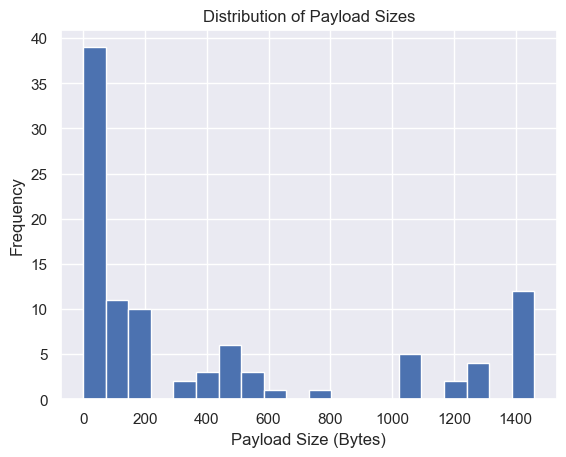

In [14]:
import matplotlib.pyplot as plt
plt.hist(df['payload'], bins=20)
plt.title("Distribution of Payload Sizes")
plt.xlabel("Payload Size (Bytes)")
plt.ylabel("Frequency")
plt.show()

# Finding potentially suspicious adresses

Now that we have graphed all those. Lets try to display the adresses which might e suspicious according to their payload.

#### GeoIP
Since this is end of all the steps. I am implementing an geoip database which we can try to use for the suspicious IP. This data base is GeoLite City database, which provides information about the Country and City of the IP adress. 

#### Alerting
Not only that but also we implemented a alerting system regarding high traffic. For now we made the treshold 10000 but this can be adjusted.

ALERT: High traffic from 192.168.1.1 (14000 bytes)
GeoIP Information for Top Source Address (192.168.1.1): N/A


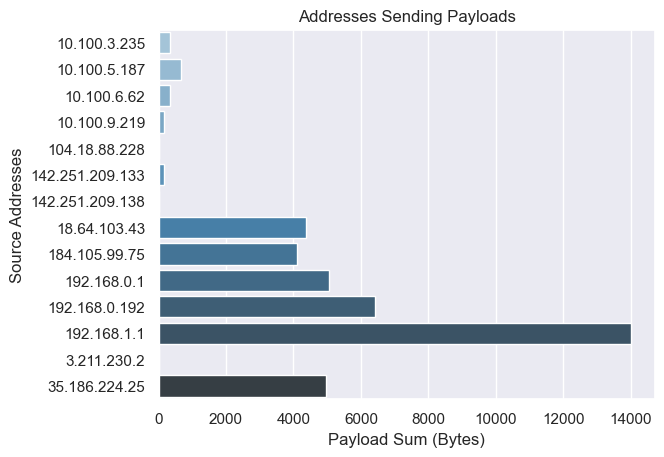

In [15]:
import geoip2.database

# Set the threshold for alerting (you can adjust this)
alert_threshold = 10000

# Initialize the GeoIP database (replace with the path to your GeoIP database file)
geoip_reader = geoip2.database.Reader('D:\\GeoLite\\GeoLite2-City.mmdb')



def get_geoip_info(ip_address):
    try:
        response = geoip_reader.city(ip_address)
        return f"{response.country.name}, {response.city.name}"
    except Exception as e:
        return "N/A"


    # GeoIP information for source and destination
    source_geoip = get_geoip_info(packet[IP].src)
    dest_geoip = get_geoip_info(packet[IP].dst)

    field_values.append(source_geoip)
    field_values.append(dest_geoip)

    # Add row to DF
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index(drop=True)

# Alerting
# Convert the 'payload' column to numeric
df['payload'] = pd.to_numeric(df['payload'], errors='coerce')

# Calculate payload sum for each source address
source_payloads = df.groupby('src')['payload'].sum()

for source, payload_sum in source_payloads.items():
    if payload_sum > alert_threshold:
        print(f"ALERT: High traffic from {source} ({payload_sum} bytes)")

# Find the top source address based on payload sum
if not source_payloads.empty:
    top_source = source_payloads.idxmax()
    print(f"GeoIP Information for Top Source Address ({top_source}): {get_geoip_info(top_source)}")
else:
    print("No data available for GeoIP lookup.")

# Now you can use df for further analysis and visualization

# Sample visualization:
source_addresses = df.groupby("src")['payload'].sum()
sns.barplot(y=source_addresses.index, x=source_addresses, orient="h", palette="Blues_d")
plt.title("Addresses Sending Payloads")
plt.xlabel("Payload Sum (Bytes)")
plt.ylabel("Source Addresses")
plt.show()

## Full code of the program
The code has all of the libararies, alerting mechanism and geo IP database implemented in one batch.

Enjoy!

ALERT: High traffic from 192.168.1.1 (14000 bytes)
GeoIP Information for Top Source Address (192.168.1.1): N/A (Private/Multicast/Loopback Address)


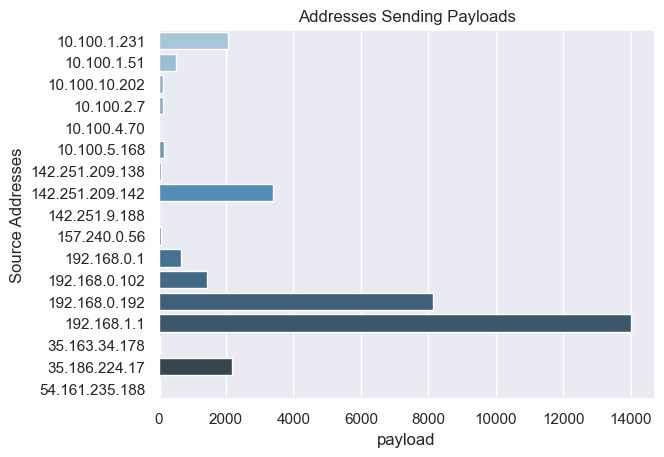

In [16]:
from scapy.all import *
import pandas as pd
import binascii
import seaborn as sns
import geoip2.database

# Set the threshold for alerting (you can adjust this)
alert_threshold = 10000

# Initialize the GeoIP database (replace with the path to your GeoIP database file)
geoip_reader = geoip2.database.Reader('D:\\GeoLite\\GeoLite2-City.mmdb')

num_of_packets_to_sniff = 100
pcap = sniff(count=num_of_packets_to_sniff)

# Append suspicious pcap to the current stream
# rdpcap is used to read Pcap
pcap = pcap + rdpcap("high_payload_burst.pcap")

# Collect field names from IP/TCP/UDP (These will be columns in DF)
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload', 'payload_raw', 'payload_hex', 'source_geoip', 'destination_geoip']

# Create a blank DataFrame
df = pd.DataFrame(columns=dataframe_fields)

def get_geoip_info(ip_address):
    if ip_address.startswith(('10.', '192.168.', '127.', '224.', '239.')):
        return "N/A (Private/Multicast/Loopback Address)"
    try:
        response = geoip_reader.city(ip_address)
        return f"{response.country.name}, {response.city.name}"
    except Exception as e:
        print(f"GeoIP lookup error: {str(e)}")
        return "N/A"


# Modify the code for packet analysis
for packet in pcap[IP]:
    field_values = []

    for field in ip_fields:
        if field == 'options':
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])

    field_values.append(packet.time)

    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)

    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))

    # GeoIP information for source and destination
    source_geoip = get_geoip_info(packet[IP].src)
    dest_geoip = get_geoip_info(packet[IP].dst)

    field_values.append(source_geoip)
    field_values.append(dest_geoip)

    # Add row to DF
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index(drop=True)

# Alerting
# Convert the 'payload' column to numeric
df['payload'] = pd.to_numeric(df['payload'], errors='coerce')

# Calculate payload sum for each source address
source_payloads = df.groupby('src')['payload'].sum()

for source, payload_sum in source_payloads.items():
    if payload_sum > alert_threshold:
        print(f"ALERT: High traffic from {source} ({payload_sum} bytes)")

# Find the top source address based on payload sum
if not source_payloads.empty:
    top_source = source_payloads.idxmax()
    print(f"GeoIP Information for Top Source Address ({top_source}): {get_geoip_info(top_source)}")
else:
    print("No data available for GeoIP lookup.")

# Now you can use df for further analysis and visualization

# Sample visualization:
source_addresses = df.groupby("src")['payload'].sum()
sns.barplot(y=source_addresses.index, x=source_addresses, orient="h", palette="Blues_d")
plt.title("Addresses Sending Payloads")
plt.ylabel("Source Addresses")
plt.show()


In [17]:
from scapy.all import *

# Define the source and destination IP addresses
src_ip = "192.168.1.1"
dst_ip = "192.168.1.2"

# Define the payload size (adjust as needed)
payload_size = 1400  # Smaller payload size

# Number of packets to generate
num_packets = 10

# Create a list of packets with high payloads
packets = []

for _ in range(num_packets):
    payload_data = b"X" * payload_size
    packet = IP(src=src_ip, dst=dst_ip) / TCP() / Raw(load=payload_data)
    packets.append(packet)

# Save the packets to a .pcap file
wrpcap("high_payload_burst.pcap", packets)

print(f"{num_packets} packets with high payloads have been saved to high_payload_burst.pcap.")


10 packets with high payloads have been saved to high_payload_burst.pcap.


In [18]:
# Group the DataFrame by source IP and calculate the total payload for each IP
ip_payloads = df.groupby('src')['payload'].sum()

# Sort the IP addresses by payload in descending order and select the top 15
top_15_ip_addresses = ip_payloads.sort_values(ascending=False).head(15)

# Print the top 15 distinct IP addresses with their payload sums and GeoIP information
for ip_address, payload_sum in top_15_ip_addresses.items():
    geo_info = get_geoip_info(ip_address)
    print(f"IP Address: {ip_address}, Payload Sum: {payload_sum} bytes, GeoIP Location: {geo_info}")


IP Address: 192.168.1.1, Payload Sum: 14000 bytes, GeoIP Location: N/A (Private/Multicast/Loopback Address)
IP Address: 192.168.0.192, Payload Sum: 8140 bytes, GeoIP Location: N/A (Private/Multicast/Loopback Address)
IP Address: 142.251.209.142, Payload Sum: 3392 bytes, GeoIP Location: United States, None
IP Address: 35.186.224.17, Payload Sum: 2184 bytes, GeoIP Location: United States, Kansas City
IP Address: 10.100.1.231, Payload Sum: 2060 bytes, GeoIP Location: N/A (Private/Multicast/Loopback Address)
IP Address: 192.168.0.102, Payload Sum: 1426 bytes, GeoIP Location: N/A (Private/Multicast/Loopback Address)
IP Address: 192.168.0.1, Payload Sum: 670 bytes, GeoIP Location: N/A (Private/Multicast/Loopback Address)
IP Address: 10.100.1.51, Payload Sum: 510 bytes, GeoIP Location: N/A (Private/Multicast/Loopback Address)
IP Address: 10.100.5.168, Payload Sum: 175 bytes, GeoIP Location: N/A (Private/Multicast/Loopback Address)
IP Address: 10.100.10.202, Payload Sum: 125 bytes, GeoIP Locat